In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
import os
sys.path.append('/'.join(os.getcwd().split('/')[:4]))
from config.get import cfg
from tensorflow import keras
from tensorflow.keras import layers
import autoencoders

2022-01-09 14:41:48.072289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 14:41:48.072326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loaidng data

In [2]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(5354, 3, 600, 2),X_test=(1340, 3, 600, 2)


# Loading model

In [3]:

model_name,autoencoder = autoencoders.fully_connected_3L()
autoencoder.summary()
train_loss = []

2022-01-09 14:41:55.772879: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-09 14:41:55.772932: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (izar): /proc/driver/nvidia/version does not exist
2022-01-09 14:41:55.774262: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 600, 2)]       0         
                                                                 
 reshape (Reshape)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 600)               2160600   
                                                                 
 dense_1 (Dense)             (None, 100)               60100     
                                                                 
 dense_2 (Dense)             (None, 600)               60600     
                                                                 
 dense_3 (Dense)             (None, 3600)              2163600   
                                                                 
 reshape_1 (Reshape)         (None, 3, 600, 2)         0     

In [4]:
hist = autoencoder.fit(X_train, X_train,epochs=150)

Epoch 1/150
168/168 [==============================] - 21s 122ms/step - loss: 0.3216
Epoch 2/150
168/168 [==============================] - 21s 127ms/step - loss: 0.2003
Epoch 3/150
168/168 [==============================] - 21s 127ms/step - loss: 0.1793
Epoch 4/150
168/168 [==============================] - 21s 124ms/step - loss: 0.1684
Epoch 5/150
168/168 [==============================] - 21s 128ms/step - loss: 0.1600
Epoch 6/150
168/168 [==============================] - 21s 125ms/step - loss: 0.1564
Epoch 7/150
168/168 [==============================] - 21s 123ms/step - loss: 0.1527
Epoch 8/150
168/168 [==============================] - 21s 124ms/step - loss: 0.1499
Epoch 9/150
168/168 [==============================] - 21s 125ms/step - loss: 0.1473
Epoch 10/150
168/168 [==============================] - 20s 122ms/step - loss: 0.1466
Epoch 11/150
168/168 [==============================] - 20s 122ms/step - loss: 0.1438
Epoch 12/150
168/168 [==============================] - 21s 123

168/168 [==============================] - 21s 128ms/step - loss: 0.1185
Epoch 97/150
168/168 [==============================] - 21s 125ms/step - loss: 0.1189
Epoch 98/150
168/168 [==============================] - 21s 124ms/step - loss: 0.1187
Epoch 99/150
168/168 [==============================] - 21s 125ms/step - loss: 0.1184
Epoch 100/150
168/168 [==============================] - 21s 125ms/step - loss: 0.1192
Epoch 101/150
168/168 [==============================] - 21s 125ms/step - loss: 0.1187
Epoch 102/150
168/168 [==============================] - 22s 128ms/step - loss: 0.1188
Epoch 103/150
168/168 [==============================] - 21s 125ms/step - loss: 0.1181
Epoch 104/150
168/168 [==============================] - 22s 128ms/step - loss: 0.1184
Epoch 105/150
168/168 [==============================] - 21s 124ms/step - loss: 0.1186
Epoch 106/150
168/168 [==============================] - 21s 126ms/step - loss: 0.1191
Epoch 107/150
168/168 [==============================] - 21s

In [5]:
train_loss+=hist.history["loss"]

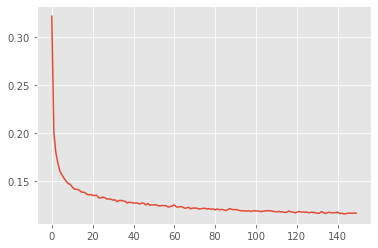

In [6]:
plt.plot(train_loss)
plt.show()

# Saving 

In [8]:
autoencoder.save(cfg["models"]["autoencoder"] + f"{model_name}")

In [10]:
np.save(file = cfg["models"]["autoencoder"]+ f"{model_name}_train_loss", arr = np.array(train_loss))

# testing 

In [31]:
def mean_squared_error(x,y):
    return np.sum((x-y)**2)/x.size

train_pred = autoencoder(X_train).numpy()
test_pred  = autoencoder(X_test).numpy()

print(f"MSE train : {mean_squared_error(train_pred,X_train)} \nMSE test  : {mean_squared_error(test_pred,X_test)}")

MSE train : 0.6656895960779817 
MSE test  : 0.672439797862461
